In [203]:
#!conda install --yes -c conda-forge cufflinks-py

# Introduction

Bitcoin (BTC) is proposed to provided a modern era store of value and be a potential successor to Gold (GLD) in this respect (Ammous, 2018). Ammous (2018) illustrates that one of the key determinate factors of both BTC and GLD in confering this property is that they both demonstrate a high stock-to-flow ratio.

Stock-to-flow refers to the property by which the current global stock or holding of an asset compares to the potential incomming flow of that asset. For example, the global stock of GLD compared to the potential new production of GLD is very high - i.e. its a rare metal on Earth and the effort of extraction of new GLD only accounts for some 2% of the stock. This is compared to the potential stock-to-flow of fiat currency whereby government issued paper (no longer backed by anything like a gold standard) can be printed / minted readily (with little effort) thus large quantities of new flow can devalue currently held stock, leading to inflationary periods and the consequent socio-economic results. The economic model of BTC is purported to resemble that of GLD as BTC miners are effectively expending a larger amount of resource and effort in minting new Bitcions. In addition the total global supply of BTC is capped to 22 million; this should result in a deflationary currency.

In this study this notebook will:

1. Investigate the potential correlation between BTC and GLD returns in timeseries, assuming a positive correlation indicates some representation whereby BTC is also considered a store of value.
2. Machine learning will be applied to determine if the trades into BTC or GLD can be recommended (it is suspected that the recent activities driving the price of BTC higher could result in an extremely simple, hold only strategy)

If there is time the study will also look at the relationship between these _store-of-value_ assets and an index such as the FTSE to ascertain whether there is a clear negative correlation.


In [472]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [291]:
# import libraries

import os
import pandas as pd
import numpy as np
import time

import cufflinks as cf
import plotly.offline as plyo
#pd.options.plotting.backend = "plotly"
cf.go_offline()

from pylab import mpl, plt
plt.style.use('seaborn')
%matplotlib inline

# libraries for analysis with GPU

#import cupy as cp
#import cudf
#import dask_cudf

The project does not require a full Extract Transform Load (ETL) pipeline, we do however need to extract and potentially clean the data after a period of discovery. The extraction and initial analysis of daily BTC (from the exchange Binance (2021) follows).

In [292]:

df_BTC_USD_daily = pd.read_csv('crypto_data/Binance_BTCUSDT_d.csv', skiprows=1)

In [293]:
df_BTC_USD_daily.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.611187e+12,2021-01-21 00:00:00,BTC/USDT,35468.23,35600.00,35304.63,35319.06,307.752511,1.091121e+07,10161.0
1,1.611101e+12,2021-01-20 00:00:00,BTC/USDT,35901.94,36415.31,33400.00,35468.23,89368.422918,3.126721e+09,2234539.0
2,1.611014e+12,2021-01-19 00:00:00,BTC/USDT,36622.46,37850.00,35844.06,35891.49,79611.307769,2.935348e+09,1939371.0
3,1.610928e+12,2021-01-18 00:00:00,BTC/USDT,35824.99,37469.83,34800.00,36631.27,70698.118750,2.554843e+09,1707766.0
4,1.610842e+12,2021-01-17 00:00:00,BTC/USDT,35994.98,36852.50,33850.00,35828.61,80157.727384,2.843103e+09,1860642.0


In [294]:
df_BTC_USD_daily.describe()

,unix,open,high,low,close,Volume BTC,Volume USDT,tradecount
count,1.255000e+03,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03,1.131000e+03
mean,1.408150e+12,8997.216932,9271.379044,8686.398733,9021.788510,45626.800031,4.717578e+08,5.154053e+05
std,4.667163e+11,5081.027649,5312.224687,4807.335260,5133.340739,34889.453619,6.460202e+08,4.662954e+05
min,1.502928e+09,3189.020000,3276.500000,2817.000000,3189.020000,225.760000,9.677533e+05,1.016100e+04
25%,1.529928e+12,6391.540000,6537.500000,6260.500000,6393.135000,25434.349423,1.708942e+08,2.159290e+05
50%,1.557014e+12,8184.970000,8382.800000,7954.000000,8187.170000,38896.639746,3.073169e+08,3.573820e+05
75%,1.584101e+12,10235.730000,10455.000000,9900.000000,10242.875000,59211.513017,5.189953e+08,6.468370e+05
max,1.611187e+12,40586.960000,41950.000000,38720.000000,40582.810000,402201.673764,8.426880e+09,4.431451e+06


In [295]:
df_BTC_USD_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         1255 non-null   float64
 1   date         1255 non-null   object 
 2   symbol       1255 non-null   object 
 3   open         1255 non-null   float64
 4   high         1255 non-null   float64
 5   low          1255 non-null   float64
 6   close        1255 non-null   float64
 7   Volume BTC   1255 non-null   float64
 8   Volume USDT  1255 non-null   float64
 9   tradecount   1131 non-null   float64
dtypes: float64(8), object(2)
memory usage: 98.2+ KB


It appears that there are some missing trade count values though other values seem ok.

In [296]:
df_BTC_USD_daily.isna().sum()

unix             0
date             0
symbol           0
open             0
high             0
low              0
close            0
Volume BTC       0
Volume USDT      0
tradecount     124
dtype: int64

It appears that there are null values for trade count. Upon inspection it seems that the missing values for trade count occur near the start of the data, assuming that Binance where not publishing these values during this time period.
TODO: ensure that the tradecounts are only for early data
TODO: can fill with the average, is it useful?

In [298]:
df_BTC_USD_daily[df_BTC_USD_daily['tradecount'].isna()]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1131,1.513555e+09,2017-12-18,BTC/USDT,18860.02,19300.00,17029.98,18856.25,10280.98,1.900573e+08,NaN
1132,1.513469e+09,2017-12-17,BTC/USDT,19102.66,19798.68,18510.00,18860.02,8980.73,1.721134e+08,NaN
1133,1.513382e+09,2017-12-16,BTC/USDT,17539.83,19539.00,17190.01,19102.66,4118.28,7.473658e+07,NaN
1134,1.513296e+09,2017-12-15,BTC/USDT,16334.98,17991.00,16298.45,17539.83,8999.13,1.566451e+08,NaN
1135,1.513210e+09,2017-12-14,BTC/USDT,16033.29,16445.00,15450.00,16334.98,11220.26,1.797144e+08,NaN
...,...,...,...,...,...,...,...,...,...,...
1250,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.12,2.770592e+06,NaN
1251,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.54,1.915636e+06,NaN
1252,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.15,1.508239e+06,NaN
1253,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.07,4.994494e+06,NaN


We can now see that the data is daily Open, Low, High, Close (OLHC) with associated Volumes and Tradecounts. We can further visualise and analyse this data if we treat it like true timeseries data in Pandas. We can also note that first column (index_col=0), whilst representing the timeseries is a unix epoch time, we therefore reimport the data using pandas indicating that the date colum (index_col=1) is the true indicator of the time series. Pandas will automatically account for this and correctly build the timeseries index.

In [299]:
df_BTC_USD_daily = pd.read_csv('crypto_data/Binance_BTCUSDT_d.csv', skiprows=1, index_col=1, parse_dates=True)

Viewing the head of the dataframe we can see that the data has been correctly indexed with the date indicating the timeseries.

In [302]:
df_BTC_USD_daily.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
date,,,,,,,,,
2021-01-21,1.611187e+12,BTC/USDT,35468.23,35600.00,35304.63,35319.06,307.752511,1.091121e+07,10161.0
2021-01-20,1.611101e+12,BTC/USDT,35901.94,36415.31,33400.00,35468.23,89368.422918,3.126721e+09,2234539.0
2021-01-19,1.611014e+12,BTC/USDT,36622.46,37850.00,35844.06,35891.49,79611.307769,2.935348e+09,1939371.0
2021-01-18,1.610928e+12,BTC/USDT,35824.99,37469.83,34800.00,36631.27,70698.118750,2.554843e+09,1707766.0
2021-01-17,1.610842e+12,BTC/USDT,35994.98,36852.50,33850.00,35828.61,80157.727384,2.843103e+09,1860642.0


In [303]:
df_olhc = df_BTC_USD_daily[['open','high','low','close']]

In [304]:
df_olhc.head()

,open,high,low,close
date,,,,
2021-01-21,35468.23,35600.00,35304.63,35319.06
2021-01-20,35901.94,36415.31,33400.00,35468.23
2021-01-19,36622.46,37850.00,35844.06,35891.49
2021-01-18,35824.99,37469.83,34800.00,36631.27
2021-01-17,35994.98,36852.50,33850.00,35828.61


In [305]:
df_olhc.tail()

,open,high,low,close
date,,,,
2017-08-21,4086.29,4119.62,3911.79,4016.00
2017-08-20,4139.98,4211.08,4032.62,4086.29
2017-08-19,4108.37,4184.69,3850.00,4139.98
2017-08-18,4285.08,4371.52,3938.77,4108.37
2017-08-17,4469.93,4485.39,4200.74,4285.08


Visualisation of data often benefits from domain specific representations. In this case illustrating OHLC trade data using Candlestick charting (this originally was a Japanese method, used to help illustrate potential patterns in data that could result in new insight and trading strategies).

In this visualisation method the Open and Close prices are represened by the body of the _candle_ (forming a box for each daily price quad). If the closing price is higher than the opening price the body of the candle is white, if the closing price is lower than the opening price the body color is darker (in this case blue). The _wicks_ of the candle represent the daily extremes of pricing. So the bottom line extending from the body is the lowest price experienced during the time period and the top line extending from the body is the highest price experienced for the period.

We will respresent the OHLC data for BTC daily here using the Cufflinks Python library (recommended by Hilpisch, 2020?).

In [309]:
qf = cf.QuantFig(
    df_olhc.iloc[:50], # take the 50 last prices
    title='BTC/USD Exchange Rate - Daily',
    legend='top',
    name='BTC/USD'
)

In [310]:
plyo.iplot(
    qf.iplot(asFigure=True),
    #image='png',
    #filename='btc_01'
)

In [311]:
df_olhc.pct_change().head()

,open,high,low,close
date,,,,
2021-01-21,NaN,NaN,NaN,NaN
2021-01-20,0.012228,0.022902,-0.053948,0.004223
2021-01-19,0.020069,0.039398,0.073175,0.011933
2021-01-18,-0.021775,-0.010044,-0.029128,0.020612
2021-01-17,0.004745,-0.016475,-0.027299,-0.021912


Information from visualising the daily prices using this method is clearly higher than a more traditional line graph as shown below. Here we can select only the closing price, otherwise for all prices a multi series chart which does little to allay confusion.

In [312]:
df_BTC_close_daily = pd.DataFrame(df_olhc['close'])
plyo.iplot(
    df_BTC_close_daily.iplot(asFigure=True)
)

In this next section we borrow some further techniques from Hilpisch (2020) to further illustrate relationships in the data to help convey information. These also explore our ability to use rolling window calculating in Python Pandas.

1. plotting mean max and average of closing prices.
2. sub-plots of closing price, volumes and tradecounts.
3. applying a very simple fast-slow EMA strategy - to see if anything we produce using Machine Learning (ML) can out perform one of the most simple non-fundamentals analysis strategies.

In [313]:
window = 20
df_BTC_close_daily.sort_index(axis=0 ,ascending=True, inplace=True)
df_BTC_close_daily['min']  = df_BTC_close_daily['close'].rolling(window=window).min()
df_BTC_close_daily['max']  = df_BTC_close_daily['close'].rolling(window=window).max()
df_BTC_close_daily['mean']  = df_BTC_close_daily['close'].rolling(window=window).mean()
df_BTC_close_daily['median']  = df_BTC_close_daily['close'].rolling(window=window).median()
df_BTC_close_daily['ewma']  = df_BTC_close_daily['close'].ewm(halflife=0.5, min_periods=window).mean()

<AxesSubplot:xlabel='date'>

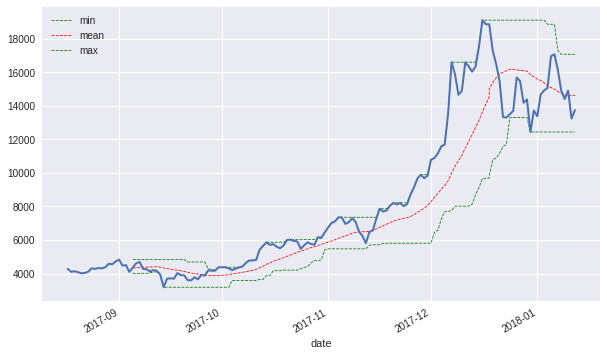

In [314]:
pd.options.plotting.backend='matplotlib' 
ax = df_BTC_close_daily[['min','mean','max']].iloc[:150].plot(figsize=(10,6),style=['g--','r--','g--'],lw=0.8)
df_BTC_close_daily['close'].iloc[:150].plot(ax=ax, lw=2.0)

Subplots of the closing price, trade count and average trade size are plotted. It was of interest to see what relationship the tradesize, so the average tradesize was calculated and ploted.

It seems that the number of trades increased with price as did the average trade size. Though earlier trade sizes where also larger (driven by an unknown factor).

It seems that increased number of trades could represent liquidity and this liquidity could also increase the value of the asset.

In [316]:
df_BTC_USD_daily['USD_avg_tradesize'] = df_BTC_USD_daily['Volume USDT'] / df_BTC_USD_daily['tradecount']

df_BTC_close_trades_daily = pd.DataFrame(df_BTC_USD_daily[['close','tradecount','USD_avg_tradesize']])
plyo.iplot(
    df_BTC_close_trades_daily.iplot(asFigure=True,
    subplots=True)
)

In the section that follows we utilise a simple method from Hilpisch (2020) that utilises a fast and slow Simple Moving Average (SMA) to indicate Buy Sell signals. In this case when the Fast SMA trendline moves over the Slow SMA trendline a long position in BTC is indicated. The general trend of BTC has been to move upwards within this time frame, though as a basic signal this indicator looks like it would have been positive if what simplistic.

<AxesSubplot:xlabel='date'>

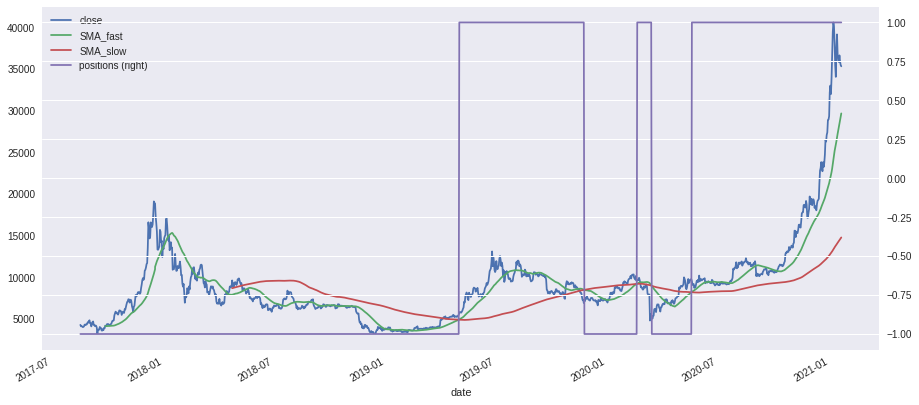

In [318]:
df_BTC_close_daily.sort_index(axis=0 ,ascending=True, inplace=True)
df_BTC_close_daily['SMA_fast'] = df_BTC_close_daily['close'].rolling(window=42).mean()
df_BTC_close_daily['SMA_slow'] = df_BTC_close_daily['close'].rolling(window=252).mean()
df_BTC_close_daily['positions'] = np.where(df_BTC_close_daily['SMA_fast'] > df_BTC_close_daily['SMA_slow'],1,-1)
df_BTC_close_daily[['close','SMA_fast','SMA_slow','positions']].plot(figsize=(15,7), secondary_y='positions', grid=False)


Now we load the gold prices from Yahoo Finance (2021) and explore.

In [365]:
df_GOLD_USD_daily = pd.read_csv('crypto_data/gold_usd_prices.csv', skiprows=0)

In [366]:
df_GOLD_USD_daily.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-02-01,1116.699951,1130.000000,1115.300049,1127.900024,1127.900024,1682.0
1,2016-02-02,1128.300049,1131.400024,1123.000000,1127.300049,1127.300049,1230.0
2,2016-02-03,1128.500000,1146.000000,1125.000000,1141.300049,1141.300049,1630.0
3,2016-02-04,1142.500000,1157.599976,1141.000000,1157.599976,1157.599976,771.0
4,2016-02-05,1155.599976,1174.800049,1146.000000,1157.800049,1157.800049,877.0
5,2016-02-07,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-02-08,1173.500000,1200.400024,1165.000000,1197.900024,1197.900024,931.0
7,2016-02-09,1188.699951,1199.199951,1186.699951,1198.699951,1198.699951,700.0
8,2016-02-10,1189.800049,1197.699951,1182.099976,1194.699951,1194.699951,671.0
9,2016-02-11,1205.599976,1260.800049,1204.599976,1247.900024,1247.900024,995.0


We can see already null values. 

In [367]:
from datetime import datetime
import calendar

In [368]:
date = datetime(2016,2,7)

In [369]:
calendar.day_name[date.weekday()] 

'Sunday'

We can see that the null date is a Sunday and the preceding day of the 6th of February 2016 is missing. Lets look further and see what dates are missing.

In [370]:
print(datetime.strptime('2016-02-07', "%Y-%m-%d"))

2016-02-07 00:00:00


In [371]:
calendar.day_name[datetime.strptime('2016-02-07', "%Y-%m-%d").weekday()]

'Sunday'

In [372]:
df_GOLD_USD_daily['day_name'] = df_GOLD_USD_daily_dates['day_name'] = df_GOLD_USD_daily['Date'].apply(lambda x: calendar.day_name[datetime.strptime(x, "%Y-%m-%d").weekday()])

In [373]:
df_GOLD_USD_daily[df_GOLD_USD_daily['Low'].isna()].groupby('day_name').count()

,Date,Open,High,Low,Close,Adj Close,Volume
day_name,,,,,,,
Friday,4,0,0,0,0,0,0
Monday,4,0,0,0,0,0,0
Sunday,261,0,0,0,0,0,0
Thursday,1,0,0,0,0,0,0
Tuesday,2,0,0,0,0,0,0
Wednesday,1,0,0,0,0,0,0


It seems likely that the missing dates, predominantly Sundays are holidays and the prices were not available to collect. Regardless of the reason to plot a chart, for example, would display breaks in continuity for these days. It seems reasonable to fill the missing data with that of the previous day to retain time series continuity.

In [375]:
df_GOLD_USD_daily = df_GOLD_USD_daily.fillna(method='ffill')

Now convert gold prices to a time series data frame.

In [376]:
df_GOLD_USD_daily['Date'] = pd.to_datetime(df_GOLD_USD_daily['Date'])

In [377]:
df_GOLD_USD_daily.index = df_GOLD_USD_daily['Date']

In [378]:
df_GOLD_USD_daily.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_name
Date,,,,,,,,
2016-02-01,2016-02-01,1116.699951,1130.000000,1115.300049,1127.900024,1127.900024,1682.0,Monday
2016-02-02,2016-02-02,1128.300049,1131.400024,1123.000000,1127.300049,1127.300049,1230.0,Tuesday
2016-02-03,2016-02-03,1128.500000,1146.000000,1125.000000,1141.300049,1141.300049,1630.0,Wednesday
2016-02-04,2016-02-04,1142.500000,1157.599976,1141.000000,1157.599976,1157.599976,771.0,Thursday
2016-02-05,2016-02-05,1155.599976,1174.800049,1146.000000,1157.800049,1157.800049,877.0,Friday


It should now be possible to plot another simple SMA trading strategy chart for the gold data to see how it differs from that of BTC.

<AxesSubplot:xlabel='Date'>

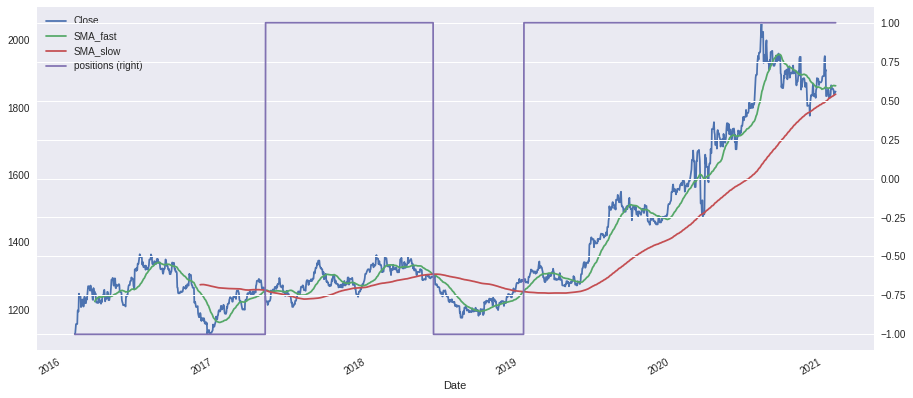

In [381]:
df_GOLD_USD_daily.sort_index(axis=0 ,ascending=True, inplace=True)
df_GOLD_USD_daily['SMA_fast'] = df_GOLD_USD_daily['Close'].rolling(window=42).mean()
df_GOLD_USD_daily['SMA_slow'] = df_GOLD_USD_daily['Close'].rolling(window=252).mean()
df_GOLD_USD_daily['positions'] = np.where(df_GOLD_USD_daily['SMA_fast'] > df_GOLD_USD_daily['SMA_slow'],1,-1)
df_GOLD_USD_daily[['Close','SMA_fast','SMA_slow','positions']].plot(figsize=(15,7), secondary_y='positions', grid=False)


So already we can see a similarity between BTC and GLD. Lets see what a correlation analysis reveals.

In [422]:
df_BTC_USD_daily.sort_index(axis=0 ,ascending=True, inplace=True)
# get data from 2018 onward only to match the time periods studied
df_BTC_USD_daily_2018_plus = df_BTC_USD_daily.loc['2018-01-03':'2021-01-21']
df_GOLD_USD_daily_2018_plus = df_GOLD_USD_daily.loc['2018-01-03':'2021-01-21']

In [423]:
# now only select the closing prices

In [424]:
df_BTC_USD_daily_2018_plus.rename(columns={'close' : 'BTC'},inplace=True)
df_GOLD_USD_daily_2018_plus.rename(columns={'Close' : 'GLD'}, inplace=True)

In [427]:
df_BTC_USD_daily_2018_plus.head(1)

,unix,symbol,open,high,low,BTC,Volume BTC,Volume USDT,tradecount,USD_avg_tradesize
date,,,,,,,,,,
2018-01-03,1.514938e+12,BTC/USDT,14690.0,15307.56,14150.0,14919.51,15905.667639,2.361169e+08,162787.0,1450.465137


In [428]:
df_GOLD_USD_daily_2018_plus.head(1)

,Date,Open,High,Low,GLD,Adj Close,Volume,day_name,SMA_fast,SMA_slow,positions
Date,,,,,,,,,,,
2018-01-03,2018-01-03,1320.0,1320.099976,1312.099976,1316.199951,1316.199951,42.0,Wednesday,1275.711908,1267.515478,1


In [429]:
df_BTC_GLD_plus_2018 = df_BTC_USD_daily_2018_plus.join(df_GOLD_USD_daily_2018_plus)

In [432]:
df_BTC_GLD_plus_2018 = df_BTC_GLD_plus_2018[['BTC','GLD']]

In [434]:
# fill forward days that are created by the join. BTC data is for every day within the timeframe
df_BTC_GLD_plus_2018 = df_BTC_GLD_plus_2018.fillna(method='ffill')

In df_BTC_GLD_plus_2018 we have merged the closing gold prices and filled in any null values to ensure continuity of each series.

We can now determine the log returns for each and determine the extent of the correlation.

In [442]:
df_BTC_GLD_plus_2018_returns = np.log(df_BTC_GLD_plus_2018 / df_BTC_GLD_plus_2018.shift(1))

In [443]:
df_BTC_GLD_plus_2018_returns.dropna(inplace=True)

In [448]:
df_BTC_GLD_plus_2018

,BTC,GLD
date,,
2018-01-03,14919.51,1316.199951
2018-01-04,15059.54,1319.400024
2018-01-05,16960.39,1320.300049
2018-01-06,17069.79,1320.300049
2018-01-07,16150.03,1320.300049
...,...,...
2021-01-17,35828.61,1829.300049
2021-01-18,36631.27,1829.300049
2021-01-19,35891.49,1839.500000


We can also follow the lead of Hilpisch (2020) and utiles ordinary least-squares (OLS) regression to determine the extent of correlation.

In [445]:
reg = np.polyfit(df_BTC_GLD_plus_2018_returns['BTC'],df_BTC_GLD_plus_2018_returns['GLD'],deg=1)

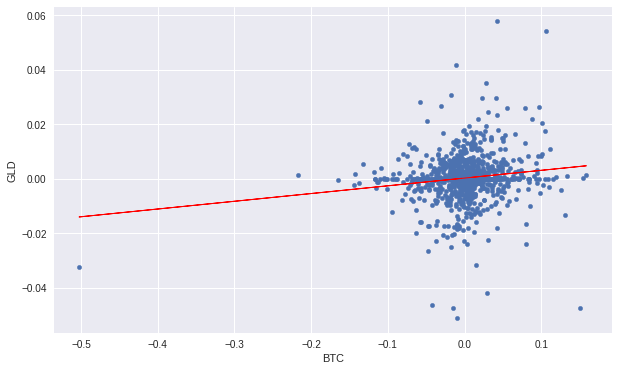

In [467]:
ax1 = df_BTC_GLD_plus_2018_returns.plot(kind='scatter', x='BTC', y='GLD', figsize=(10,6))
ax1.plot(df_BTC_GLD_plus_2018_returns['BTC'],np.polyval(reg, df_BTC_GLD_plus_2018_returns['BTC']),'r',lw=1)

The correlation matrix can be demonstrated, thus:

In [468]:
cmatrix = df_BTC_GLD_plus_2018_returns.corr()
cmatrix

,BTC,GLD
BTC,1.000000,0.143089
GLD,0.143089,1.000000


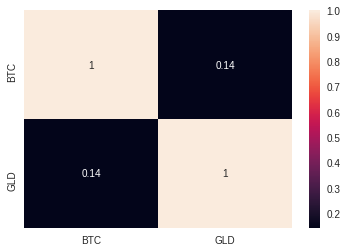

In [469]:
import seaborn as sn
sn.heatmap(cmatrix, annot=True)
plt.show()

We can see that the correlation seems negligible. 

Because the data is time series the correlation can be plotted overtime to determine if there are periods where this correlation is stronger (the following method is quoted from Hilpisch 2020).

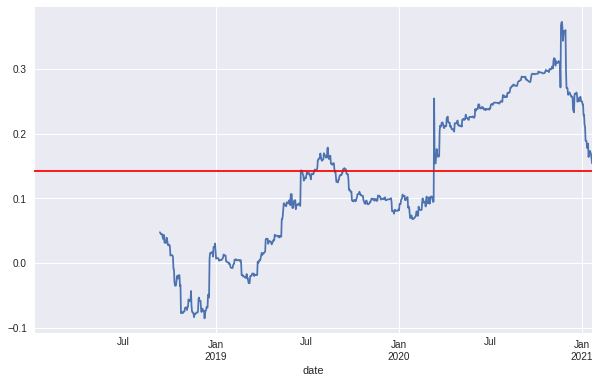

In [473]:
ax2 = df_BTC_GLD_plus_2018_returns['BTC'].rolling(window=252).corr(df_BTC_GLD_plus_2018_returns['GLD']).plot(figsize=(10,6))
ax2.axhline(df_BTC_GLD_plus_2018_returns.corr().iloc[0,1],c='r')

Correlation analysis over time series points to negative correlation prior Jan 2020, thereafter positive. This however could be attributed to some other hidden factors or other global econmic situations (speculation though possibly the coronavirus pandemic). The hypothesis at the outset were true, that GLD and BTC should show some correlation if they are both considered stores of value. This does not appear to be the case prior to Jan 2020 though correlation seems to have increased after Jan 2020 though a continual trend upwards has been shown in the data set from the origin time. Regardless, the correlation is still weak at under 0.3: it would be interesting to follow the trend over time. Does this increasing correlation really mean that BTC is becoming more like gold? The immediate plummet at the end of Jan could be demonstrating the impact related to Elon Musk's recent twitter profile change, thus the price of BTC jumping by means of sentiment in the market over its potentially growing role as a store of value.